In [115]:
# transfer of learning for perturbation, using the idea of backprop + hebbian

# Feb14: it happens that not giving boundary to perturbation period while giving boundary to non-perturbation period produces the best result
# giving boundary might cause convergence to boundary (high loss), for example, when shifts want to jump below 1
# not giving boundary might sink into a local minimum where the loss is really low but gains and shifts are deviant from initial

# Feb24: if no boundary, the even the original trained model will be unstable.
# Also the perturbation inside sigmoid. Only in fortunate cases like perturbation outside sigmoid could converge.
# If turn off perturbation when unstable, the recover would be quite quick and random.
# I guess this is because tiny difference between output and target cause modification on gains and shifts and in turn cause weights to change.
# But adding boundaries when perturbation would cause convergence to boundary (that's ok) and high loss (not ok).

# Feb25: even if no boundary, the original model with a small outside-sigmoid perturbation (0.04) would be unstable for a long time, but eventually converge after 5000 epochs.
# Same for the inside-sigmoid perturbation, which needs many epoches to converge.

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from training_abb05_bphebb import SimpleNeuralNetwork
from tqdm.notebook import tqdm
from perturbation_exp import PerturbNetwork

In [117]:
# load the pickle file
with open('weights_abb05_bphebb.pkl', 'rb') as f:
    model_rep = pickle.load(f)

In [118]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [17]:
# bp on weight to find the hebb alpha for perturbed network
# init
input_size = 230
init_gain = 3 * np.ones((input_size, 1))
init_shift = 1 * np.ones((input_size, 1))
init_weight = np.ones((1, input_size)) * 5.5 / input_size

# Training Loop
weight_epochs = 200
backprop_lr = 0.01

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=weight_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises += 0.1

# record
weight_losses = []
weight_sums = []
# weights = []

for epoch in tqdm(range(weight_epochs), position=0, leave=True):
    
    # establish model
    model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    epoch_loss = 0

    # go through all data
    for x, y in zip(shuffled_xs, shuffled_ys):  
        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift) + (x_noises[:, epoch]).reshape(-1, 1))
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
        model.output_activation = actv_opl.clone()          
        output = actv_opl.squeeze()
        # Calculate loss
        loss_func = nn.MSELoss()
        loss = 0.5 * loss_func(output, y)
        
        # backprop
        optimizer = optim.SGD([model.weights], lr=backprop_lr)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    # update init
    init_gain = model.gain.detach().numpy()
    init_shift = model.shift.detach().numpy()
    init_weight = model.weights.detach().numpy()

    # record
    epoch_loss /= ndata
    weight_losses.append(epoch_loss)
    weight_sums.append(np.sum(init_weight))

    # print out info
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{weight_epochs}, Loss: {epoch_loss}, Sum: {np.sum(init_weight)}')


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Loss: 0.00076145851590532, Sum: 5.163771629333496
Epoch 11/200, Loss: 4.2776428854640614e-07, Sum: 5.166690826416016
Epoch 21/200, Loss: 5.795033710231934e-08, Sum: 5.166904926300049
Epoch 31/200, Loss: 3.0856784480892686e-08, Sum: 5.166866302490234
Epoch 41/200, Loss: 2.6248721101129745e-08, Sum: 5.166419982910156
Epoch 51/200, Loss: 2.6595841382537345e-08, Sum: 5.167218208312988
Epoch 61/200, Loss: 2.664890973225198e-08, Sum: 5.166940689086914
Epoch 71/200, Loss: 2.637860708976092e-08, Sum: 5.166751384735107
Epoch 81/200, Loss: 2.7238900877080142e-08, Sum: 5.166522979736328
Epoch 91/200, Loss: 2.6765483991386675e-08, Sum: 5.167330741882324
Epoch 101/200, Loss: 2.6071328023125063e-08, Sum: 5.167067527770996
Epoch 111/200, Loss: 2.5423937586310786e-08, Sum: 5.166662216186523
Epoch 121/200, Loss: 2.608484810373568e-08, Sum: 5.167096138000488
Epoch 131/200, Loss: 2.5885317913587613e-08, Sum: 5.167163372039795
Epoch 141/200, Loss: 2.6413825422455517e-08, Sum: 5.16664028167724

### Single Perturbation Test

In [144]:
simulator = PerturbNetwork(model_rep, simu_epochs=4000, perturb_last=2500, only_backprop_epoch=0, perturb_amp=1)
simu_losses, gain_changes, shift_changes, simu_weights, simu_gains, simu_shifts, model_final = simulator.simulate(ndata=200, seed=0, perturb_in_sigmoid=True)

  1%|▏         | 53/4000 [00:02<02:51, 23.08it/s]

perturbation start!!!


  2%|▏         | 62/4000 [00:02<02:49, 23.19it/s]

perturb learning start!!!


 64%|██████▍   | 2552/4000 [01:54<01:03, 22.65it/s]

perturbation end!!!
origin learning start!!!
origin boundary created!!!


100%|██████████| 4000/4000 [03:02<00:00, 21.91it/s]


In [60]:
# # perturbation for 2000 epochs
# simu_epochs = 4000
# perturb_start = 50
# perturb_last = 2000
# input_size = 230
# theo_gain = 3 * np.ones((input_size, 1))
# theo_shift = 1 * np.ones((input_size, 1))
# init_gain = model_rep.gain.detach().numpy()
# init_shift = model_rep.shift.detach().numpy()
# init_weight = model_rep.weights.detach().numpy()
# hebbian_lr = 0.0001
# max_hebbian_lr = 0.0001
# hebbian_up_rate = max_hebbian_lr / 100
# hebb_alpha = 5.5
# hebb_alpha_origin = 5.5
# hebb_alpha_perturb = 5.5  # 3.5
# hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 100
# backprop_lr = 0.2
# has_backprop = True
# has_boundary = False
# has_hebbian = True
# has_perturb = False

# # define noise
# np.random.seed(42)
# W = np.eye(input_size) * 0.001
# x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
# x_noises = torch.tensor(x_noises, dtype=torch.float32)
# x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

# simu_losses = []
# gain_changes = []
# shift_changes = []
# weight_sums = []
# epoch_loss = 0

# for epoch in tqdm(range(simu_epochs), position=0, leave=True):
#     if epoch == perturb_start:
#         has_perturb = True
#         has_hebbian = False
#         has_boundary = False
#         hebbian_lr = 0
#         print("perturbation start!!!")
#     if epoch == perturb_start + perturb_last:
#         has_perturb = False
#         has_hebbian = False
#         has_boundary = False
#         hebbian_lr = 0
#         print("perturbation end!!!")
   
#     # shuffle data
#     perm_idx = torch.randperm(ndata)
#     shuffled_xs = xs[perm_idx]
#     shuffled_ys = ys[perm_idx]
#     last_epoch_loss = epoch_loss
#     epoch_loss = 0

#     # start hebbian and shrinkage
#     if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#         has_hebbian = True
#         print("perturb learning start!!!")
#     if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#         has_hebbian = True
#         print("origin learning start!!!")
#     # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#     #     gain_ub = np.maximum(init_gain, theo_gain) + 0.1
#     #     gain_lb = np.minimum(init_gain, theo_gain) - 0.1
#     #     shift_ub = np.maximum(init_shift, theo_shift) + 0.1
#     #     shift_lb = np.minimum(init_shift, theo_shift) - 0.1
#     #     has_boundary = True
#     #     print("perturb boundary created!!!")
#     if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#         gain_ub = np.maximum(init_gain, theo_gain)
#         gain_lb = np.minimum(init_gain, theo_gain)
#         shift_ub = np.maximum(init_shift, theo_shift)
#         shift_lb = np.minimum(init_shift, theo_shift)
#         has_boundary = True
#         print("origin boundary created!!!")
        
#     # update hebbian learning rate, once per epoch
#     if has_hebbian and hebbian_lr < max_hebbian_lr:
#         hebbian_lr += hebbian_up_rate
#     if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
#         hebb_alpha += hebb_alpha_up_rate
#     if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
#         hebb_alpha -= hebb_alpha_up_rate
    
#     # go through all data
#     for x, y in zip(shuffled_xs, shuffled_ys):  
#         # establish model
#         model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)
#         # forward
#         inpu_ipl = model.gaussian_rf(x)
#         actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
#         # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
#         model.input_activation = actv_ipl.clone()
#         inpu_opl = torch.matmul(model.weights, actv_ipl)
#         actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
#         model.output_activation = actv_opl.clone()          
#         output = actv_opl.squeeze()
#         # Calculate loss
#         loss_func = nn.MSELoss()
#         loss = 0.5 * loss_func(output, y)
#         epoch_loss += loss

#         # backprop for gains and shifts
#         if has_backprop:
#             optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#         # update init gains and shifts
#         init_gain = model.gain.detach().numpy()
#         init_shift = model.shift.detach().numpy()
#         gain_change = np.linalg.norm(init_gain - theo_gain, 2)
#         shift_change = np.linalg.norm(init_shift - theo_shift, 2)

#         # hebbian learning for weights
#         if has_hebbian:
#             # Calculate Hebbian weight updates
#             hebbian_update = model.output_activation * (model.input_activation).T
#             # Apply Hebbian updates and normalize
#             model.weights = model.weights + hebbian_lr * hebbian_update
#             model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
#         # update init weights
#         init_weight = model.weights.detach().numpy()

#         # shrink shift and gain to init value
#         if has_boundary:
#             # passively narrow the boundaries
#             # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
#             # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
#             # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
#             # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
#             # pull gains and shifts back to into boundaries
#             init_gain = np.minimum(init_gain, gain_ub)
#             init_gain = np.maximum(init_gain, gain_lb)
#             init_shift = np.minimum(init_shift, shift_ub)
#             init_shift = np.maximum(init_shift, shift_lb)

#     # print losses
#     epoch_loss /= ndata
#     if epoch % 20 == 0:
#         print(f"Epoch: {epoch}, Loss: {epoch_loss}")
#         # print(f"Gains: {init_gain[0:10].flatten()}")
#         # print(f"Shifts: {init_shift[0:10].flatten()}")

#     # record
#     simu_losses.append(epoch_loss.item())
#     weight_sums.append(np.sum(init_weight))
#     gain_changes.append(gain_change)
#     shift_changes.append(shift_change)

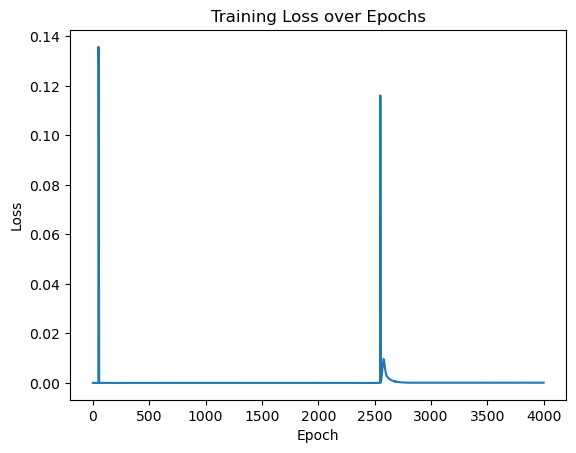

In [145]:
# Plotting the loss
plt.plot(range(len(simu_losses)), simu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.02])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.show()

In [93]:
# # Plotting the outputs
# model.eval()
# outputs = []
# for x in xs:
#     output = model(x)
#     outputs.append(output.item())
# plt.plot(xs, outputs)
# plt.plot(xs, ys, label='target')
# plt.ylim([0,1])
# plt.xlabel("theta")
# # plt.savefig('abb05_outputs.png')
# plt.show()

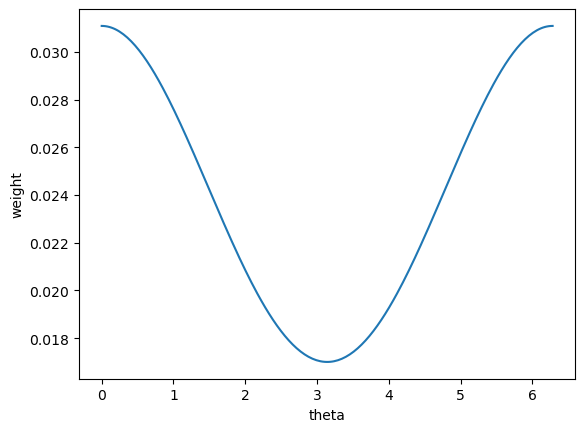

In [146]:
final_weight = model_final.weights.detach().numpy()
plt.plot(np.linspace(0, 2 * np.pi, model_final.input_size), final_weight.flatten())
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
# plt.savefig('abb05_ws.png')
plt.show()

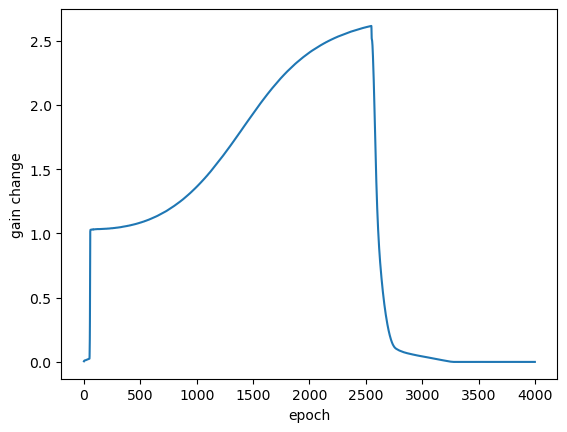

In [147]:
plt.plot(np.arange(len(simu_losses)), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

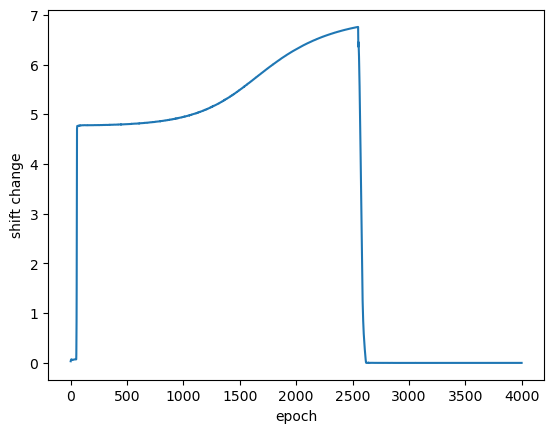

In [148]:
plt.plot(np.arange(len(simu_losses)), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

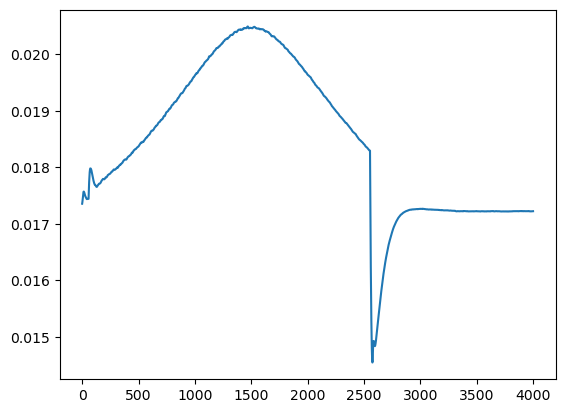

In [149]:
# extract the first element in each weight
i = 105
first_weights = [weight[:,i].item() for weight in simu_weights]
plt.plot(np.arange(len(first_weights)), first_weights)

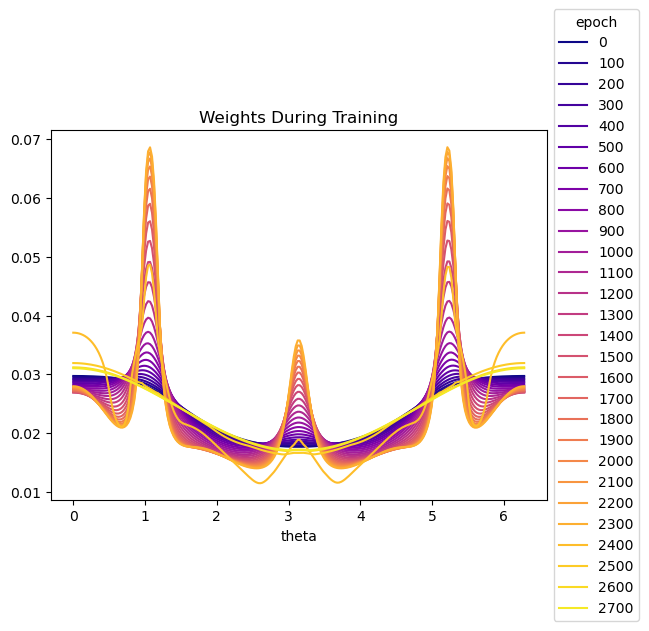

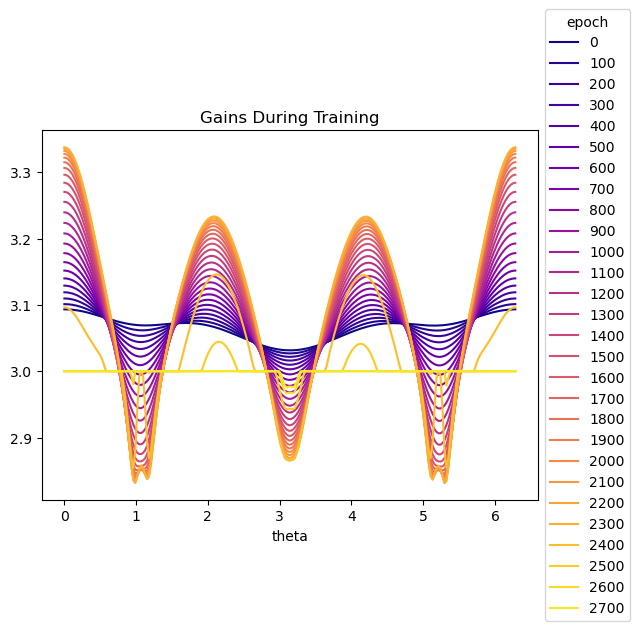

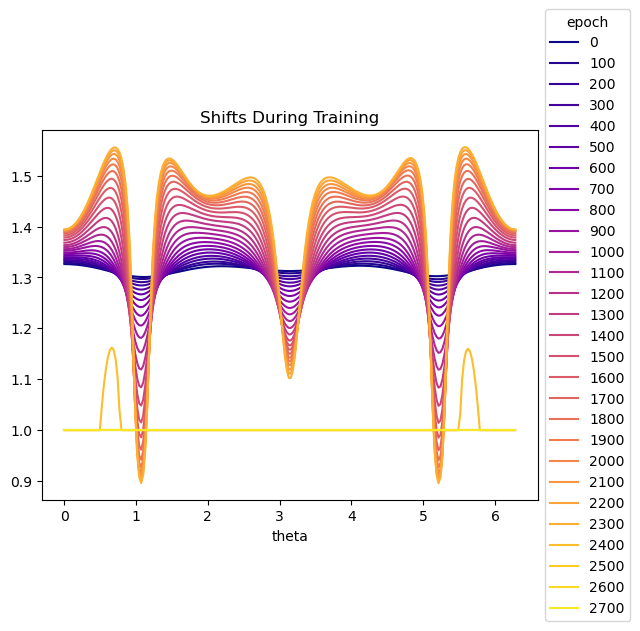

In [152]:
inspect_start = 200
inspect_end = 3000
inspect_step = 100

# plot weight
weights_to_plot = simu_weights[inspect_start:inspect_end]
for i, weight in enumerate(weights_to_plot):
    if i % inspect_step == 0:
        plt.plot(np.linspace(0, 2 * np.pi, model_final.input_size), weight.flatten(), color=plt.cm.plasma((i+1)/len(weights_to_plot)), label=str((i)))
plt.xlabel("theta")
plt.title("Weights During Training")
plt.legend(title='epoch', loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()

# plot gain
gains_to_plot = simu_gains[inspect_start:inspect_end]
for i, gain in enumerate(gains_to_plot):
    if i % inspect_step == 0:
        plt.plot(np.linspace(0, 2 * np.pi, model_final.input_size), gain.flatten(), color=plt.cm.plasma((i+1)/len(gains_to_plot)), label=str((i)))
plt.xlabel("theta")
plt.legend(title='epoch', loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("Gains During Training")
plt.show()

# plot shift
shifts_to_plot = simu_shifts[inspect_start:inspect_end]
for i, shift in enumerate(shifts_to_plot):
    if i % inspect_step == 0:
        plt.plot(np.linspace(0, 2 * np.pi, model_final.input_size), shift.flatten(), color=plt.cm.plasma((i+1)/len(shifts_to_plot)), label=str((i)))
plt.xlabel("theta")
plt.legend(title='epoch', loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("Shifts During Training")
plt.show()

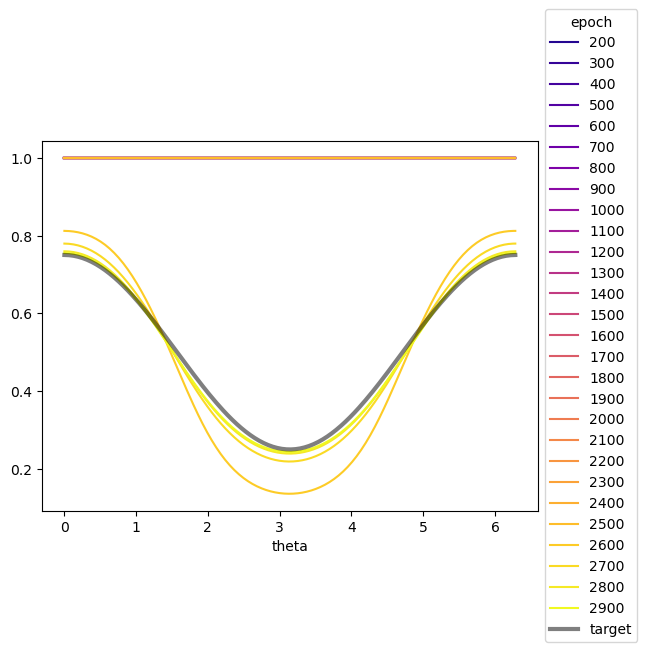

In [153]:
# Plotting the outputs for each epoch
for i, epoch in enumerate(range(inspect_start, inspect_end, inspect_step)):
    model = SimpleNeuralNetwork(model_rep.input_size, simu_gains[epoch], simu_shifts[epoch], simu_weights[epoch])
    # model.gain = model_rep.init_gain
    # model.shift = model_rep.init_shift
    outputs = []
    for x in xs:
        # forward
        inpu_ipl = model.gaussian_rf(x)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift) + (simulator.x_noises[:, epoch]).reshape(-1, 1))
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (simulator.x_noises[:, epoch]).reshape(-1, 1)
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
        model.output_activation = actv_opl.clone()          
        output = actv_opl.squeeze()
        outputs.append(output.item())
        # if x == 0:
        #     print(inpu_ipl)
        #     print(actv_ipl)
        #     print(actv_opl)
    plt.plot(xs, outputs, color=plt.cm.plasma((i+1)/len(range(inspect_start, inspect_end, inspect_step))), label=str((epoch)))

plt.plot(xs, ys, label='target', color='black', alpha=0.5, lw=3)
# plt.ylim([0,1])
plt.xlabel("theta")
plt.legend(title='epoch', loc='center left',bbox_to_anchor=(1, 0.5))

In [20]:
# rates = []
# for x in xs:
#     input = model.gaussian_rf(x)
#     rate = model.activation_func(model.gain * (input - model.shift))
#     rates.append(rate)
# rates = torch.cat(rates, dim=1)
# rates = rates.detach().numpy().round(4)

# for i in np.arange(0,model.input_size,10):
#     thisr = rates[i,:]
#     plt.plot(xs, thisr)
# plt.xlabel("theta")
# plt.ylabel("firing rate")
# # plt.savefig('abb05_rf.png')

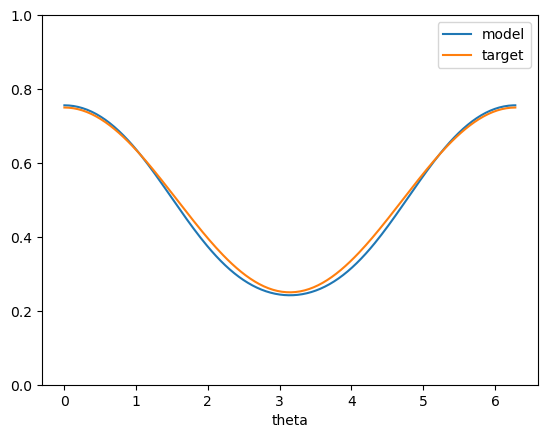

In [154]:
# Plotting the outputs
model_final.gain = model_rep.init_gain
model_final.shift = model_rep.init_shift
model.eval()
outputs = []
for x in xs:
    output = model_final(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
# plt.savefig('abb05_outputs_nosup.png')

In [155]:
perturb_last = 2500
perturb_start = 50
origin_start = perturb_start + perturb_last

recover_cost = 0
recover_epoch = 0
for i, loss in enumerate(simu_losses):
    if i > origin_start:
        if loss < 0.0001:
            break
        if loss < 1:
            recover_cost += loss
            recover_epoch += 1

print(recover_cost)
print(recover_epoch)

0.4860977086282219
251


### Different Perturbation Amp

In [ ]:
# # manual simulation
# perturb_lasts = [1000, 2000, 5000]

# all_simu_losses = []
# all_gain_changes = []
# all_shift_changes = []
# all_weight_sums = []

# for perturb_last in perturb_lasts:

#     print(f"perturb_last: {perturb_last}")

#     simu_epochs = 8000
#     perturb_start = 50
#     # perturb_last = 500
#     input_size = 230
#     theo_gain = 3 * np.ones((input_size, 1))
#     theo_shift = 1 * np.ones((input_size, 1))
#     init_gain = model_rep.gain.detach().numpy()
#     init_shift = model_rep.shift.detach().numpy()
#     init_weight = model_rep.weights.detach().numpy()
#     hebbian_lr = 0.0001
#     max_hebbian_lr = 0.0001
#     hebbian_up_rate = max_hebbian_lr / 100
#     hebb_alpha = 5.5
#     hebb_alpha_origin = 5.5
#     hebb_alpha_perturb = 5.5
#     hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 100
#     backprop_lr = 0.2
#     has_backprop = True
#     has_boundary = False
#     has_hebbian = True
#     has_perturb = False

#     # define noise
#     np.random.seed(42)
#     W = np.eye(input_size) * 0.001
#     x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
#     x_noises = torch.tensor(x_noises, dtype=torch.float32)
#     x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

#     simu_losses = []
#     gain_changes = []
#     shift_changes = []
#     weight_sums = []
#     epoch_loss = 0

#     for epoch in tqdm(range(simu_epochs), position=0, leave=True):
#         if epoch == perturb_start:
#             has_perturb = True
#             has_hebbian = False
#             has_boundary = False
#             hebbian_lr = 0
#             print("perturbation start!!!")
#         if epoch == perturb_start + perturb_last:
#             has_perturb = False
#             has_hebbian = False
#             has_boundary = False
#             hebbian_lr = 0
#             print("perturbation end!!!")
        
#         # shuffle data
#         perm_idx = torch.randperm(ndata)
#         shuffled_xs = xs[perm_idx]
#         shuffled_ys = ys[perm_idx]
#         last_epoch_loss = epoch_loss
#         epoch_loss = 0

#         # start hebbian and shrinkage
#         if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#             has_hebbian = True
#             print("perturb learning start!!!")
#         if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#             has_hebbian = True
#             print("origin learning start!!!")
#         # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#         #     gain_ub = np.maximum(init_gain, theo_gain)
#         #     gain_lb = np.minimum(init_gain, theo_gain)
#         #     shift_ub = np.maximum(init_shift, theo_shift)
#         #     shift_lb = np.minimum(init_shift, theo_shift)
#         #     has_boundary = True
#         #     print("perturb boundary created!!!")
#         if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#             gain_ub = np.maximum(init_gain, theo_gain)
#             gain_lb = np.minimum(init_gain, theo_gain)
#             shift_ub = np.maximum(init_shift, theo_shift)
#             shift_lb = np.minimum(init_shift, theo_shift)
#             has_boundary = True
#             print("origin boundary created!!!")
     
#         # update hebbian learning rate, once per epoch
#         if has_hebbian and hebbian_lr < max_hebbian_lr:
#             hebbian_lr += hebbian_up_rate
#         if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
#             hebb_alpha += hebb_alpha_up_rate
#         if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
#             hebb_alpha -= hebb_alpha_up_rate
        
#         # go through all data
#         for x, y in zip(shuffled_xs, shuffled_ys):  
#             # establish model
#             model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)
#             # forward
#             inpu_ipl = model.gaussian_rf(x)
#             actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
#             # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
#             model.input_activation = actv_ipl.clone()
#             inpu_opl = torch.matmul(model.weights, actv_ipl)
#             actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
#             model.output_activation = actv_opl.clone()          
#             output = actv_opl.squeeze()
#             # Calculate loss
#             loss_func = nn.MSELoss()
#             loss = 0.5 * loss_func(output, y)
#             epoch_loss += loss

#             # backprop for gains and shifts
#             if has_backprop:
#                 optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
#                 loss.backward()
#                 optimizer.step()
#                 optimizer.zero_grad()
#             # update init gains and shifts
#             init_gain = model.gain.detach().numpy()
#             init_shift = model.shift.detach().numpy()
#             gain_change = np.linalg.norm(init_gain - theo_gain, 2)
#             shift_change = np.linalg.norm(init_shift - theo_shift, 2)

#             # hebbian learning for weights
#             if has_hebbian:
#                 # Calculate Hebbian weight updates
#                 hebbian_update = model.output_activation * (model.input_activation).T
#                 # Apply Hebbian updates and normalize
#                 model.weights = model.weights + hebbian_lr * hebbian_update
#                 model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
#             # update init weights
#             init_weight = model.weights.detach().numpy()

#             # shrink shift and gain to init value
#             if has_boundary:
#                 # passively narrow the boundaries
#                 # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
#                 # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
#                 # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
#                 # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
#                 # pull gains and shifts back to into boundaries
#                 init_gain = np.minimum(init_gain, gain_ub)
#                 init_gain = np.maximum(init_gain, gain_lb)
#                 init_shift = np.minimum(init_shift, shift_ub)
#                 init_shift = np.maximum(init_shift, shift_lb)

#         # print losses
#         epoch_loss /= ndata
#         if epoch % 100 == 0:
#             print(f"Epoch: {epoch}, Loss: {epoch_loss}")

#         # record
#         simu_losses.append(epoch_loss.item())
#         weight_sums.append(np.sum(init_weight))
#         gain_changes.append(gain_change)
#         shift_changes.append(shift_change)
    
#     # record
#     all_simu_losses.append(simu_losses)
#     all_gain_changes.append(gain_changes)
#     all_shift_changes.append(shift_changes)
#     all_weight_sums.append(weight_sums)

In [112]:
# systematic perturbation amp
perturb_amps = [0.5, 0.8, 1, 1.2, 1.5, 1.8, 2, 2.5]

# to record
all_simu_losses = []
all_gain_changes = []
all_shift_changes = []
all_weight_sums = []
simu_epochs = 3000
perturb_last = 500

for perturb_amp in perturb_amps:
    simulator = PerturbNetwork(model_rep, simu_epochs=simu_epochs, perturb_last=perturb_last, perturb_amp=perturb_amp, only_backprop_epoch=0)
    simu_losses, weight_sums, gain_changes, shift_changes, model = simulator.simulate(ndata=200, seed=0)
    all_simu_losses.append(simu_losses)
    all_gain_changes.append(gain_changes)
    all_shift_changes.append(shift_changes)
    all_weight_sums.append(weight_sums)

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.7591777072520927e-05
perturbation start!!!
Epoch: 50, Loss: 0.04696929454803467
perturb learning start!!!
Epoch: 100, Loss: 8.08455570222577e-06
Epoch: 150, Loss: 8.146728760038968e-06
Epoch: 200, Loss: 7.79455695010256e-06
Epoch: 250, Loss: 1.0612669939291663e-05
Epoch: 300, Loss: 1.0988189387717284e-05
Epoch: 350, Loss: 1.4102739442023449e-05
Epoch: 400, Loss: 1.6620453607174568e-05
Epoch: 450, Loss: 1.2327001968515106e-05
Epoch: 500, Loss: 1.2214350135764107e-05
perturbation end!!!
Epoch: 550, Loss: 0.04246276244521141
origin learning start!!!
origin boundary created!!!
Epoch: 600, Loss: 0.0001233410876011476
Epoch: 650, Loss: 9.635752940084785e-05
Epoch: 700, Loss: 9.417095861863345e-05
Epoch: 750, Loss: 9.257060446543619e-05
Epoch: 800, Loss: 9.533707634545863e-05
Epoch: 850, Loss: 9.034491813508794e-05
Epoch: 900, Loss: 9.52814516494982e-05
Epoch: 950, Loss: 8.633768447907642e-05
Epoch: 1000, Loss: 8.420908125117421e-05
Epoch: 1050, Loss: 8.537958638044074e-05
E

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.7591777072520927e-05
perturbation start!!!
Epoch: 50, Loss: 0.12200688570737839
perturb learning start!!!
Epoch: 100, Loss: 8.224265911849216e-06
Epoch: 150, Loss: 8.23330174171133e-06
Epoch: 200, Loss: 7.973074389155954e-06
Epoch: 250, Loss: 1.0852170817088336e-05
Epoch: 300, Loss: 1.1321077181492e-05
Epoch: 350, Loss: 1.4526203813147731e-05
Epoch: 400, Loss: 1.729369250824675e-05
Epoch: 450, Loss: 1.3064605809631757e-05
Epoch: 500, Loss: 1.3099537682137452e-05
perturbation end!!!
Epoch: 550, Loss: 0.10592934489250183
origin learning start!!!
origin boundary created!!!
Epoch: 600, Loss: 0.00020248348300810903
Epoch: 650, Loss: 0.0001329953665845096
Epoch: 700, Loss: 0.00011092550266766921
Epoch: 750, Loss: 0.000100702942290809
Epoch: 800, Loss: 9.856600081548095e-05
Epoch: 850, Loss: 9.162914648186415e-05
Epoch: 900, Loss: 9.595858136890456e-05
Epoch: 950, Loss: 8.674058335600421e-05
Epoch: 1000, Loss: 8.436186180915684e-05
Epoch: 1050, Loss: 8.540713315596804e-05
Ep

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.7591777072520927e-05
perturbation start!!!
Epoch: 50, Loss: 0.1357453465461731
perturb learning start!!!
Epoch: 100, Loss: 9.138222594629042e-06
Epoch: 150, Loss: 8.844075637171045e-06
Epoch: 200, Loss: 8.663610060466453e-06
Epoch: 250, Loss: 1.1644104233710095e-05
Epoch: 300, Loss: 1.2256472473382019e-05
Epoch: 350, Loss: 1.558413714519702e-05
Epoch: 400, Loss: 1.8655069652595557e-05
Epoch: 450, Loss: 1.4526932318403851e-05
Epoch: 500, Loss: 1.4729561371495947e-05
perturbation end!!!
Epoch: 550, Loss: 0.1243320181965828
origin learning start!!!
origin boundary created!!!
Epoch: 600, Loss: 0.0002691849658731371
Epoch: 650, Loss: 0.0001622713025426492
Epoch: 700, Loss: 0.0001222447754116729
Epoch: 750, Loss: 0.00010548422142164782
Epoch: 800, Loss: 0.00010081845539389178
Epoch: 850, Loss: 9.261727973353118e-05
Epoch: 900, Loss: 9.645885438658297e-05
Epoch: 950, Loss: 8.696276927366853e-05
Epoch: 1000, Loss: 8.446526771876961e-05
Epoch: 1050, Loss: 8.545263699488714e-05

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.7591777072520927e-05
perturbation start!!!
Epoch: 50, Loss: 0.13896030187606812
perturb learning start!!!
Epoch: 100, Loss: 1.631653321965132e-05
Epoch: 150, Loss: 9.277823664888274e-06
Epoch: 200, Loss: 9.10290236788569e-06
Epoch: 250, Loss: 1.2172049537184648e-05
Epoch: 300, Loss: 1.2894131032226142e-05
Epoch: 350, Loss: 1.6364936527679674e-05
Epoch: 400, Loss: 1.9705881641129963e-05
Epoch: 450, Loss: 1.5697612980147824e-05
Epoch: 500, Loss: 1.6066718671936542e-05
perturbation end!!!
Epoch: 550, Loss: 0.1318311095237732
origin learning start!!!
origin boundary created!!!
Epoch: 600, Loss: 0.00023202273587230593
Epoch: 650, Loss: 0.00017010720330290496
Epoch: 700, Loss: 0.00012587907258421183
Epoch: 750, Loss: 0.00010696914978325367
Epoch: 800, Loss: 0.00010150221351068467
Epoch: 850, Loss: 9.291362948715687e-05
Epoch: 900, Loss: 9.660472278483212e-05
Epoch: 950, Loss: 8.70305229909718e-05
Epoch: 1000, Loss: 8.449536835541949e-05
Epoch: 1050, Loss: 8.5467028839048e-0

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.7591777072520927e-05
perturbation start!!!
Epoch: 50, Loss: 0.13993588089942932
Epoch: 100, Loss: 0.13975396752357483
perturb learning start!!!
Epoch: 150, Loss: 8.537826215615496e-05
Epoch: 200, Loss: 9.789238902158104e-06
Epoch: 250, Loss: 1.2710203918686602e-05
Epoch: 300, Loss: 1.3601221326098312e-05
Epoch: 350, Loss: 1.723675086395815e-05
Epoch: 400, Loss: 2.0997325918870047e-05
Epoch: 450, Loss: 1.715753023745492e-05
Epoch: 500, Loss: 1.781044738891069e-05
perturbation end!!!
Epoch: 550, Loss: 0.13656151294708252
origin learning start!!!
origin boundary created!!!
Epoch: 600, Loss: 0.0003505525819491595
Epoch: 650, Loss: 0.00016759688151068985
Epoch: 700, Loss: 0.0001411167613696307
Epoch: 750, Loss: 0.00011310989793855697
Epoch: 800, Loss: 0.00010431428381707519
Epoch: 850, Loss: 9.411526843905449e-05
Epoch: 900, Loss: 9.720851085148752e-05
Epoch: 950, Loss: 8.730629633646458e-05
Epoch: 1000, Loss: 8.462355617666617e-05
Epoch: 1050, Loss: 8.552272629458457e-05


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.7591777072520927e-05
perturbation start!!!
Epoch: 50, Loss: 0.14006149768829346
Epoch: 100, Loss: 0.14006046950817108
Epoch: 150, Loss: 0.14005853235721588
Epoch: 200, Loss: 0.1400568187236786
Epoch: 250, Loss: 0.14005430042743683
Epoch: 300, Loss: 0.14005114138126373
Epoch: 350, Loss: 0.14004845917224884
Epoch: 400, Loss: 0.14004351198673248
Epoch: 450, Loss: 0.14003731310367584
Epoch: 500, Loss: 0.14002838730812073
perturbation end!!!
Epoch: 550, Loss: 0.004888789262622595
origin learning start!!!
origin boundary created!!!
Epoch: 600, Loss: 5.762588989455253e-05
Epoch: 650, Loss: 6.442905578296632e-05
Epoch: 700, Loss: 7.367016951320693e-05
Epoch: 750, Loss: 8.087152673397213e-05
Epoch: 800, Loss: 8.879655797500163e-05
Epoch: 850, Loss: 8.726920350454748e-05
Epoch: 900, Loss: 9.369770850753412e-05
Epoch: 950, Loss: 8.565896860091016e-05
Epoch: 1000, Loss: 8.387215348193422e-05
Epoch: 1050, Loss: 8.519895345671102e-05
Epoch: 1100, Loss: 9.614236478228122e-05
Epoch: 

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.7591777072520927e-05
perturbation start!!!
Epoch: 50, Loss: 0.14007426798343658
Epoch: 100, Loss: 0.14007426798343658
Epoch: 150, Loss: 0.14007411897182465
Epoch: 200, Loss: 0.14007413387298584
Epoch: 250, Loss: 0.1400740146636963
Epoch: 300, Loss: 0.14007383584976196
Epoch: 350, Loss: 0.14007392525672913
Epoch: 400, Loss: 0.1400737315416336
Epoch: 450, Loss: 0.1400737166404724
Epoch: 500, Loss: 0.14007365703582764
perturbation end!!!
Epoch: 550, Loss: 9.233810851583257e-05
origin learning start!!!
origin boundary created!!!
Epoch: 600, Loss: 4.220300252200104e-05
Epoch: 650, Loss: 6.231405859580263e-05
Epoch: 700, Loss: 7.62837880756706e-05
Epoch: 750, Loss: 8.41180226416327e-05
Epoch: 800, Loss: 9.013526141643524e-05
Epoch: 850, Loss: 8.78039063536562e-05
Epoch: 900, Loss: 9.399536793353036e-05
Epoch: 950, Loss: 8.585912291891873e-05
Epoch: 1000, Loss: 8.394759788643569e-05
Epoch: 1050, Loss: 8.520630217390135e-05
Epoch: 1100, Loss: 9.61573823587969e-05
Epoch: 1150,

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.7591777072520927e-05
perturbation start!!!
Epoch: 50, Loss: 0.14007797837257385
Epoch: 100, Loss: 0.14007794857025146
Epoch: 150, Loss: 0.14007791876792908
Epoch: 200, Loss: 0.14007793366909027
Epoch: 250, Loss: 0.14007800817489624
Epoch: 300, Loss: 0.14007799327373505
Epoch: 350, Loss: 0.14007800817489624
Epoch: 400, Loss: 0.14007794857025146
Epoch: 450, Loss: 0.14007799327373505
Epoch: 500, Loss: 0.14007796347141266
perturbation end!!!
Epoch: 550, Loss: 5.813772077090107e-06
origin learning start!!!
origin boundary created!!!
Epoch: 600, Loss: 4.2025960283353925e-05
Epoch: 650, Loss: 6.448131171055138e-05
Epoch: 700, Loss: 7.780276064295322e-05
Epoch: 750, Loss: 8.493850327795371e-05
Epoch: 800, Loss: 9.058794239535928e-05
Epoch: 850, Loss: 8.80178704392165e-05
Epoch: 900, Loss: 9.410559141542763e-05
Epoch: 950, Loss: 8.590733341407031e-05
Epoch: 1000, Loss: 8.396762132178992e-05
Epoch: 1050, Loss: 8.521778363501653e-05
Epoch: 1100, Loss: 9.616536408429965e-05
Epoch

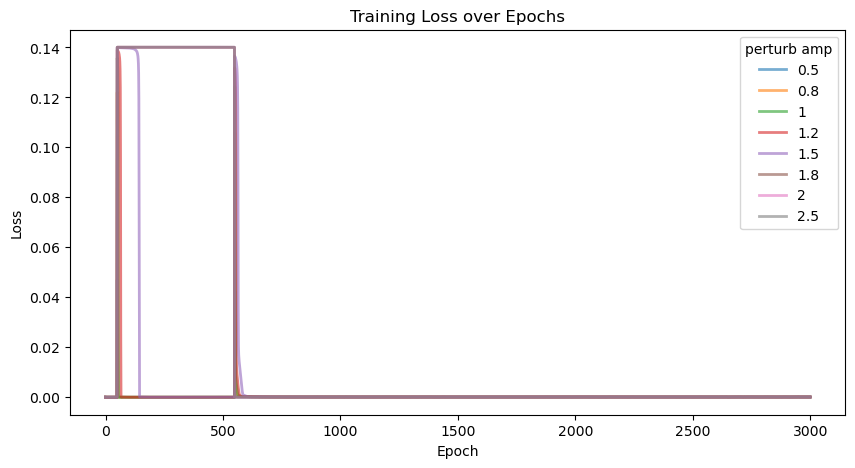

In [129]:
# Plotting the loss
fig, ax = plt.subplots(figsize=(10, 5))
for i, simu_losses in enumerate(all_simu_losses):
    # if i > 2:
    #     continue
    plt.plot(range(simu_epochs), simu_losses, label=perturb_amps[i], alpha=0.6, lw=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.02])
# plt.xlim([0,200])
plt.title('Training Loss over Epochs')
plt.legend(title='perturb amp')
plt.savefig('fig/0221_abb05_perturbamp_loss.png')
plt.show()

In [114]:
recover_costs = []
recover_epochs = []
for k in range(len(all_simu_losses)):
    simu_losses = all_simu_losses[k]
    perturb_last = 500
    perturb_start = 50
    origin_start = perturb_start + perturb_last

    recover_cost = 0
    recover_epoch = 0
    for i, loss in enumerate(simu_losses):
        if i > origin_start:
            if loss < 0.0001:
                break
            if loss < 1:
                recover_cost += loss
                recover_epoch += 1

    print(recover_cost)
    print(recover_epoch)
    recover_costs.append(recover_cost)
    recover_epochs.append(recover_epoch)

0.018835710718121845
67
0.1182454720401438
146
0.3310737109641195
161
0.738950855913572
176
2.0385331269935705
218
0.00016349116049241275
1
0
0
0
0


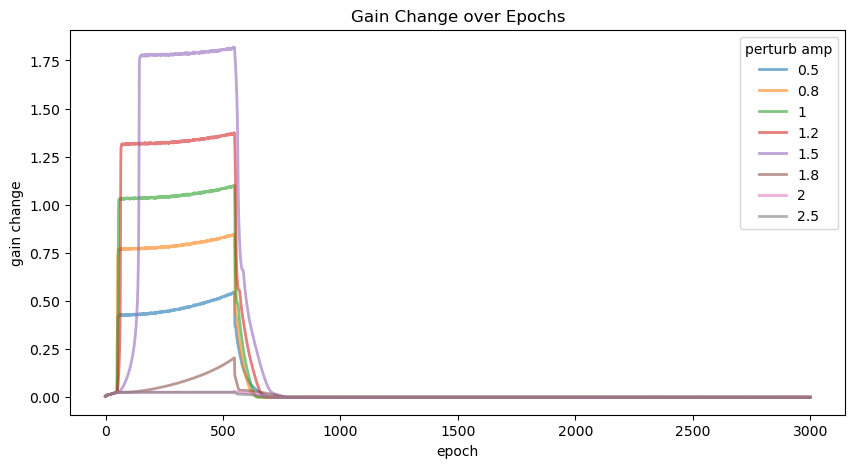

In [128]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, gain_changes in enumerate(all_gain_changes):
    plt.plot(np.arange(simu_epochs), gain_changes, label=perturb_amps[i], alpha=0.6, lw=2)
plt.xlabel("epoch")
plt.ylabel("gain change")
plt.legend(title='perturb amp')
plt.title('Gain Change over Epochs')
plt.savefig('fig/0221_abb05_perturbamp_gc.png')

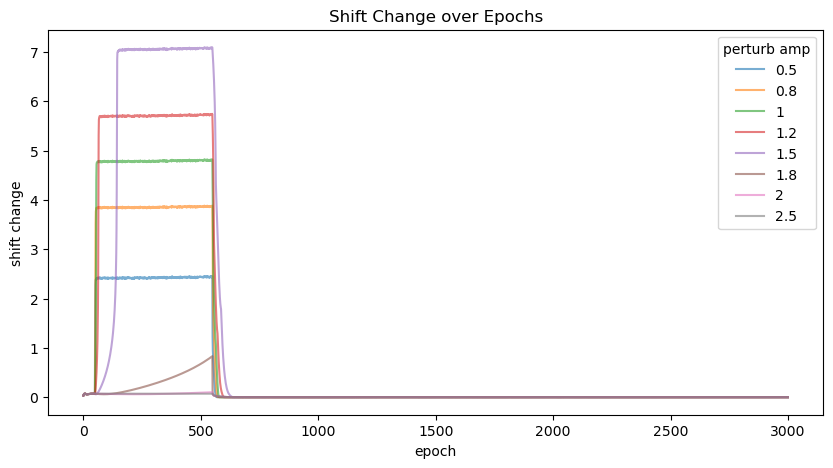

In [127]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, shift_changes in enumerate(all_shift_changes):
    plt.plot(np.arange(simu_epochs), shift_changes, label=perturb_amps[i], alpha=0.6)
plt.xlabel("epoch")
plt.ylabel("shift change")
plt.legend(title='perturb amp')
plt.title('Shift Change over Epochs')
plt.savefig('fig/0221_abb05_perturbamp_sc.png')

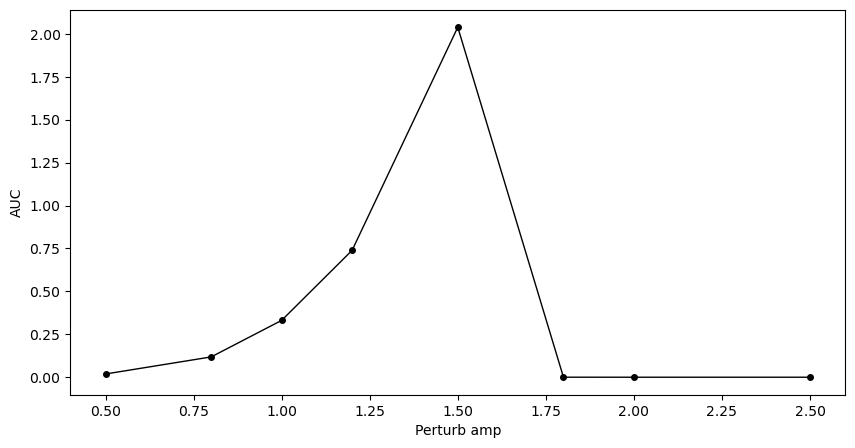

In [132]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(perturb_amps, recover_costs, marker='.', lw=1, markersize=8, color='k')
plt.ylabel('AUC')
plt.xlabel('Perturb amp')
plt.savefig('fig/0221_abb05_perturbamp_auc.png')

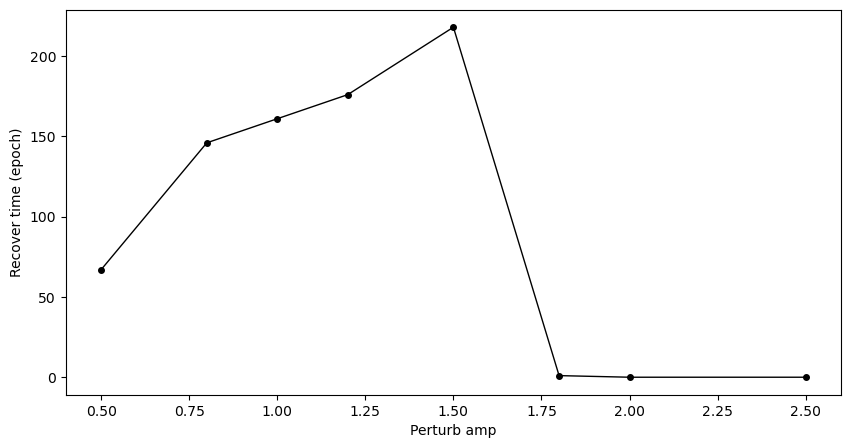

In [136]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(perturb_amps, recover_epochs, marker='.', lw=1, markersize=8, color='k')
plt.ylabel('Recover time (epoch)')
plt.xlabel('Perturb amp')
plt.savefig('fig/0221_abb05_perturbamp_rectime.png')